In [19]:
import rasterio as rio
import matplotlib.pyplot as plt 
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
import itertools

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [20]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'cpc'

yearRange = [1981, 2018]

In [22]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)


In [23]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    kdd = pickle.load(f)

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    gdd = pickle.load(f)

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


In [24]:
gpcp = xr.open_dataset('/dartfs-hpc/rc/lab/C/CMIG/GPCP/precip.mon.mean.nc', decode_cf=False)
gpcp.load()

dims = gpcp.dims
startingDate = datetime.datetime(1800, 1, 1, 0, 0, 0)
tDt = []

for curTTime in gpcp.time:
    delta = datetime.timedelta(days=int(curTTime.values))
    tDt.append(startingDate + delta)
gpcp['time'] = tDt


In [25]:
if os.path.isfile('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery):
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
else:
    seasonalPrecip = np.zeros([len(lat), len(lon), len(range(yearRange[0], yearRange[1]+1))])

    for xlat in range(len(lat)):
        if xlat % 25 == 0: print(xlat)
        for ylon in range(len(lon)):

            if ~np.isnan(sacksMaizeStart[xlat,ylon]) and ~np.isnan(sacksMaizeEnd[xlat,ylon]):
                startMonth = datetime.datetime.strptime('%d'%(sacksMaizeStart[xlat,ylon]), '%j').date().month
                endMonth = datetime.datetime.strptime('%d'%(sacksMaizeEnd[xlat,ylon]), '%j').date().month

                curPr = gpcp.precip.sel(lat=lat[xlat], lon=lon[ylon], method='nearest')

                for y, year in enumerate(range(yearRange[0], yearRange[1]+1)):

                    # in southern hemisphere when planting happens in fall and harvest happens in spring
                    if  startMonth > endMonth:
                        curPr = curPr.sel(time=slice('%d-%d'%(year-1, startMonth), '%d-%d'%(year, endMonth)))
                    else:
                        curPr = curPr.sel(time=slice('%d-%d'%(year, startMonth), '%d-%d'%(year, endMonth)))

                    seasonalPrecip[xlat, ylon, y] = np.nansum(curPr.values)
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'wb') as f:
        pickle.dump(seasonalPrecip, f)

In [26]:
kdd = kdd[:,:,1:]
gdd = gdd[:,:,1:]

In [27]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


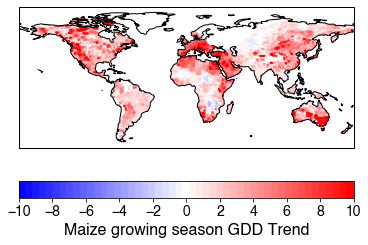

In [28]:
cRange=[-10, 10]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

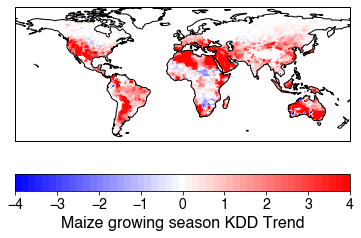

In [29]:
cRange=[-4, 4]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [30]:
# load crop yield trends from iizumi data

maize = np.zeros([360, 720, len(range(1981, 2011+1))])
maizeTrends = np.zeros([360, 720])

rice = np.zeros([360, 720, len(range(1981, 2011+1))])
riceTrends = np.zeros([360, 720])

soybean = np.zeros([360, 720, len(range(1981, 2011+1))])
soybeanTrends = np.zeros([360, 720])

wheat = np.zeros([360, 720, len(range(1981, 2011+1))])
wheatTrends = np.zeros([360, 720])

for year in range(1981, 2011+1):
    maizeNc = xr.open_dataset('%s/iizumi/maize/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    maizeNc.load()
    maizeNc = maizeNc.rename({'var':'maize_yield'})
    maize[:, :, year-1981] = np.flipud(maizeNc.maize_yield.values)
    
    soybeanNc = xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    soybeanNc.load()
    soybeanNc = soybeanNc.rename({'var':'soybean_yield'})
    soybean[:, :, year-1981] = np.flipud(soybeanNc.soybean_yield.values)
    
    riceNc = xr.open_dataset('%s/iizumi/rice/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    riceNc.load()
    riceNc = riceNc.rename({'var':'rice_yield'})
    rice[:, :, year-1981] = np.flipud(riceNc.rice_yield.values)
    
    wheatNc = xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dataDirDiscovery, year), decode_cf=False)
    wheatNc.load()
    wheatNc = wheatNc.rename({'var':'wheat_yield'})
    wheat[:, :, year-1981] = np.flipud(wheatNc.wheat_yield.values)

maize[maize < 0] = np.nan
soybean[soybean < 0] = np.nan
rice[rice < 0] = np.nan
wheat[wheat < 0] = np.nan


In [31]:
maizeDetrend = np.full(maize.shape, np.nan)
kddDetrend = np.full(kdd.shape, np.nan)
gddDetrend = np.full(gdd.shape, np.nan)

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where((~np.isnan(maize[xlat, ylon, :])) & (~np.isnan(kdd[xlat, ylon, 0:maize.shape[2]])) & (~np.isnan(gdd[xlat, ylon, 0:maize.shape[2]])))[0]
        if len(nn) == maize.shape[2]:
            maizeDetrend[xlat, ylon, nn] = scipy.signal.detrend(maize[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(maize[xlat, ylon, nn]))
            gddDetrend[xlat, ylon, nn] = scipy.signal.detrend(gdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(gdd[xlat, ylon, nn]))
            kddDetrend[xlat, ylon, nn] = scipy.signal.detrend(kdd[xlat, ylon, nn]) / np.linalg.norm(scipy.signal.detrend(kdd[xlat, ylon, nn]))
        

In [32]:
# load NASS yield data

nass1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nass2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nass3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)

nass = pd.concat([nass1[::-1], nass2[::-1], nass3[::-1]])


In [33]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [34]:
nassStates = list(nass['State'])
nassStateAbvs = []
for s in nassStates:
    nassStateAbvs.append(usStateAbbrev[s.lower().title()])
nass['StateAbvs'] = nassStateAbvs

In [35]:
if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)):
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02ap19.shp'%dataDirDiscovery)

    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360

        latInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        lonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]

        if len(latInds) == 0 or len(lonInds) == 0:
            break

        usCounties['tempLatInds'][c] = latInds
        usCounties['tempLonInds'][c] = lonInds

        latInds = np.arange(min(latInds), max(latInds)+1)
        lonInds = np.arange(min(lonInds), max(lonInds)+1)

        if len(latInds) > 1:
            countyGdd = np.nanmean(gdd[latInds, :, :], axis=0)
            countyKdd = np.nanmean(kdd[latInds, :, :], axis=0)
            countyPrecip = np.nanmean(seasonalPrecip[latInds, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[latInds, :, :])
            countyKdd = np.squeeze(kdd[latInds, :, :])
            countyPrecip = np.squeeze(seasonalPrecip[latInds, :, :])

        if len(lonInds) > 1:
            countyGdd = np.nanmean(countyGdd[lonInds, :], axis=0)
            countyKdd = np.nanmean(countyKdd[lonInds, :], axis=0)
            countyPrecip = np.nanmean(countyPrecip[lonInds, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[lonInds, :])
            countyKdd = np.squeeze(countyKdd[lonInds, :])
            countyPrecip = np.squeeze(countyPrecip[lonInds, :])

        countyGdd[countyGdd < 0] = np.nan
        usCounties['gdd'][c] = countyGdd
        
        if len(np.where(np.isnan(countyGdd))[0]) == 0:
            usCounties['gddDetrend'][c] = scipy.signal.detrend(countyGdd) 
            usCounties['gddDetrendNorm'][c] = scipy.signal.detrend(countyGdd) / np.linalg.norm(scipy.signal.detrend(countyGdd))
            
            X = sm.add_constant(range(len(countyGdd)))
            mdl = sm.OLS(countyGdd, X).fit()
            usCounties['gddTrend'][c] = mdl.params[1]
        else:
            usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['gddTrend'][c] = np.full(countyGdd.shape, np.nan)

        countyKdd[countyKdd < 0] = np.nan
        usCounties['kdd'][c] = countyKdd
        
        if len(np.where(np.isnan(countyKdd))[0]) == 0:
            usCounties['kddDetrend'][c] = scipy.signal.detrend(countyKdd) 
            usCounties['kddDetrendNorm'][c] = scipy.signal.detrend(countyKdd) / np.linalg.norm(scipy.signal.detrend(countyKdd))
            
            X = sm.add_constant(range(len(countyKdd)))
            mdl = sm.OLS(countyKdd, X).fit()
            usCounties['kddTrend'][c] = mdl.params[1]
        else:
            usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
            usCounties['kddTrend'][c] = np.full(countyKdd.shape, np.nan)
        
        
        countyPrecip[countyPrecip < 0] = np.nan
        usCounties['seasonalPrecip'][c] = countyPrecip
        
        if len(np.where(np.isnan(countyPrecip))[0]) == 0:
            usCounties['seasonalPrecipDetrend'][c] = scipy.signal.detrend(countyPrecip) 
            
            X = sm.add_constant(range(len(countyPrecip)))
            mdl = sm.OLS(countyPrecip, X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        else:
            usCounties['seasonalPrecipDetrend'][c] = np.full(countyGdd.shape, np.nan)
            usCounties['seasonalPrecipTrend'][c] = np.full(countyGdd.shape, np.nan)

        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassCounties = np.array(list(map(str.lower, nass['County'])))

        curStateName = usCounties['STATE'][c].lower()
        nassStates = np.array(list(map(str.lower, nass['StateAbvs'])))

        countyInd = np.where((curCountyName == nassCounties) & (curStateName == nassStates))[0]

        curCountyYieldYears = np.array(list(nass['Year']))
        curCountyYieldYears = curCountyYieldYears[countyInd]

        curCountyYield = np.array(list(nass['Value']))
        curCountyYield = curCountyYield[countyInd]

        yieldYearsUniform = np.arange(1981, 2018+1)
        yieldUniform = np.full(yieldYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(yieldYearsUniform):
                yieldUniform[indUniform] = curCountyYield[y]
        
        if len(np.where(np.isnan(yieldUniform))[0]) == 0:
            yieldUniformDetrendNorm = scipy.signal.detrend(yieldUniform) / np.linalg.norm(scipy.signal.detrend(yieldUniform))
            yieldUniformDetrend = scipy.signal.detrend(yieldUniform)
            
            X = sm.add_constant(range(len(yieldUniform)))
            mdl = sm.OLS(yieldUniform, X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
        else:
            yieldUniformDetrend = np.full(yieldUniform.shape, np.nan)
            yieldUniformDetrendNorm = np.full(yieldUniform.shape, np.nan)
            usCounties['maizeYieldTrend'][c] = np.nan
        
        usCounties['maizeYieldYears'][c] = yieldYearsUniform
        usCounties['maizeYield'][c] = yieldUniform
        usCounties['maizeYieldDetrend'][c] = yieldUniformDetrend
        usCounties['maizeYieldDetrendNorm'][c] = yieldUniformDetrendNorm

    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [36]:
usCounties = usCounties.drop(columns=['CWA', 'FIPS', 'TIME_ZONE', 'FE_AREA'])

# drop all counties with any nans
yieldNans = list(map(np.isnan, usCounties['maizeYield']))
gddNans = list(map(np.isnan, usCounties['gdd']))
kddNans = list(map(np.isnan, usCounties['kdd']))
inds = np.where(np.array([len(np.where((yieldNans[i]==False) & (gddNans[i]==False) & (kddNans[i]==False))[0]) for i in range(len(yieldNans))]) < 38)[0]
usCounties = usCounties.drop(index=inds)

In [37]:
yt = []
kt = []
pr = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 10: 
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        print('%s : %d : yield trend = %.1f : kdd trend = %.1f'%(state, n, \
                                                                             usCounties[usCounties['STATE']==state]['maizeYieldTrend'].mean().mean(), \
                                                                             usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean()))


IL : 65 : yield trend = 2.2 : kdd trend = 0.2
IN : 54 : yield trend = 1.8 : kdd trend = -0.0
IA : 86 : yield trend = 2.4 : kdd trend = -0.7
KS : 11 : yield trend = 1.0 : kdd trend = 1.9
KY : 35 : yield trend = 2.0 : kdd trend = 0.5
MD : 11 : yield trend = 1.9 : kdd trend = 1.5
MI : 24 : yield trend = 1.9 : kdd trend = 0.1
MN : 51 : yield trend = 2.4 : kdd trend = -0.8
MO : 19 : yield trend = 1.6 : kdd trend = 0.7
NE : 62 : yield trend = 2.0 : kdd trend = 0.3
NC : 36 : yield trend = 1.4 : kdd trend = 0.8
OH : 54 : yield trend = 1.8 : kdd trend = 0.3
PA : 20 : yield trend = 1.6 : kdd trend = 0.9
SC : 15 : yield trend = 1.3 : kdd trend = 1.2
SD : 25 : yield trend = 2.8 : kdd trend = -1.3
TN : 19 : yield trend = 2.3 : kdd trend = 0.5
TX : 20 : yield trend = 0.5 : kdd trend = 2.8
VA : 21 : yield trend = 1.7 : kdd trend = -0.0
WI : 42 : yield trend = 1.8 : kdd trend = -0.4


yield trend vs. kdd trend: coef = -0.26, p = 0.00
starting yields vs. yield trends: coef = 0.4309, p = 0.01
starting yields vs. kdd trends: coef = -2.60, p = 0.00


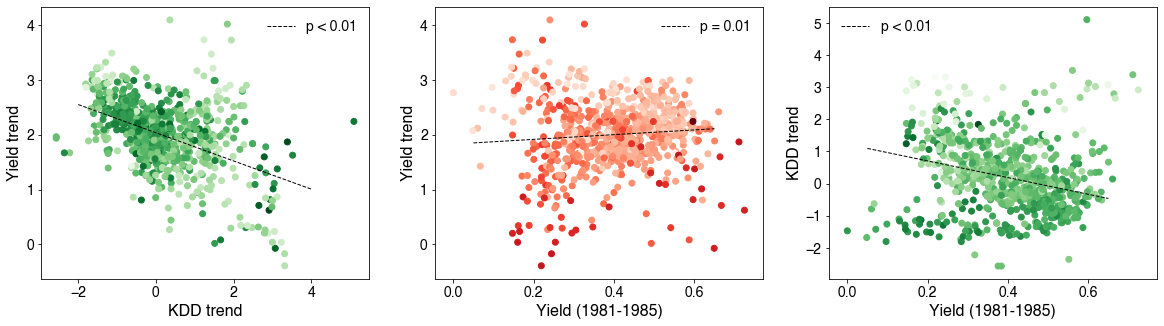

In [38]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList['maizeYieldDetrend']))

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAgg = np.array([x for x in countyList['maizeYieldTrend']])
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYield']))])))

startingYields = np.array(list(countyList['maizeYield']))
startingYields = np.nanmean(startingYields[:, 0:5], axis=1)
startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 5), nrows=1, ncols=3, squeeze=True)

X = sm.add_constant(kddTrendAgg)
mdl1 = sm.RLM(yieldTrendAgg, X).fit()

ax1.scatter(kddTrendAgg, yieldTrendAgg, c=startingYieldsNorm, cmap='Greens')
ax1.plot([-2, 4], mdl1.params[0]+[-2*mdl1.params[1], 4*mdl1.params[1]], '--k', lw=1, label = 'p < 0.01')
ax1.set_xlabel('KDD trend')
ax1.set_ylabel('Yield trend')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)


# ax2.scatter(kddValsAgg, yieldValsAgg)
# ax2.set_xlabel('KDD anomaly')
# ax2.set_ylabel('Yield anomaly')

X = sm.add_constant(startingYieldsNorm)
mdl2 = sm.RLM(yieldTrendAgg, X).fit()

ax2.scatter(startingYieldsNorm, yieldTrendAgg, c=kddTrendAggNorm, cmap='Reds')
ax2.plot([0.05, 0.65], mdl2.params[0]+[0.05*mdl2.params[1], 0.65*mdl2.params[1]], '--k', lw=1, label = 'p = 0.01')
ax2.set_xlabel('Yield (1981-1985)')
ax2.set_ylabel('Yield trend')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)


X = sm.add_constant(startingYieldsNorm)
mdl3 = sm.RLM(kddTrendAgg, X).fit()

ax3.scatter(startingYieldsNorm, kddTrendAgg, c=yieldTrendAggNorm, cmap='Greens')
ax3.plot([0.05, 0.65], mdl3.params[0]+[0.05*mdl3.params[1], 0.65*mdl3.params[1]], '--k', lw=1, label = 'p < 0.01')
ax3.set_xlabel('Yield (1981-1985)')
ax3.set_ylabel('KDD trend')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f'%(mdl1.params[1], mdl1.pvalues[1]))
print('starting yields vs. yield trends: coef = %.4f, p = %.2f'%(mdl2.params[1], mdl2.pvalues[1]))
print('starting yields vs. kdd trends: coef = %.2f, p = %.2f'%(mdl3.params[1], mdl3.pvalues[1]))


yield trend vs. kdd trend: coef = -0.03, p = 0.02
starting yields vs. kdd trends: coef = 0.83, p = 0.08


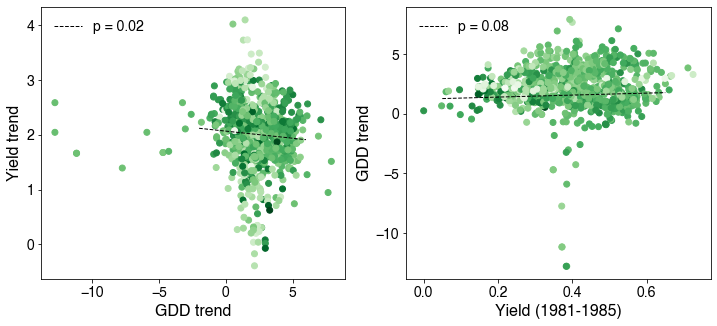

In [39]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList['maizeYieldDetrend']))

gddTrendAgg = np.array([x for x in countyList['gddTrend']])
gddTrendAggNorm = (gddTrendAgg-np.nanmin(gddTrendAgg))/np.nanmax(gddTrendAgg)
kddTrendAgg = np.array([x for x in countyList['kddTrend']])
kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAgg = np.array([x for x in countyList['maizeYieldTrend']])
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

startingYields = np.array(list(countyList['maizeYield']))
startingYields = np.nanmean(startingYields[:, 0:5], axis=1)
startingYieldsNorm = (startingYields-np.nanmin(startingYields)) / np.nanmax(startingYields)

f, (ax1, ax2) = plt.subplots(figsize=(12, 5), nrows=1, ncols=2, squeeze=True)

X = sm.add_constant(gddTrendAgg)
mdl1 = sm.RLM(yieldTrendAgg, X).fit()

ax1.scatter(gddTrendAgg, yieldTrendAgg, c=startingYieldsNorm, cmap='Greens')
ax1.plot([-2, 6], mdl1.params[0]+[-2*mdl1.params[1], 6*mdl1.params[1]], '--k', lw=1, label = 'p = 0.02')
ax1.set_xlabel('GDD trend')
ax1.set_ylabel('Yield trend')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

X = sm.add_constant(startingYieldsNorm)
mdl2 = sm.RLM(gddTrendAgg, X).fit()

ax2.scatter(startingYieldsNorm, gddTrendAgg, c=yieldTrendAggNorm, cmap='Greens')
ax2.plot([0.05, 0.65], mdl3.params[0]+[0.05*mdl2.params[1], 0.65*mdl2.params[1]], '--k', lw=1, label = 'p = 0.08')
ax2.set_xlabel('Yield (1981-1985)')
ax2.set_ylabel('GDD trend')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f'%(mdl1.params[1], mdl1.pvalues[1]))
print('starting yields vs. kdd trends: coef = %.2f, p = %.2f'%(mdl2.params[1], mdl2.pvalues[1]))


In [42]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     4316.
Date:                Tue, 10 Mar 2020   Prob (F-statistic):               0.00
Time:                        21:22:57   Log-Likelihood:            -1.1673e+05
No. Observations:               27398   AIC:                         2.335e+05
Df Residuals:                   27394   BIC:                         2.335e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.796e-14      0.104  -1.73e-13      1.000      -0.203       0.203
GDD            0.0474      0.002     28.886      0.000       0.044       0.051
KDD           -0.2297      0.003    -91.162      0.000      -0.235      -0.225
Pr             0.1357      0.042      3.254      0.001       0.054       0.217
==============================================================================
Omnibus:                     2902.826   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5375.928
Skew:                          -0.714   Prob(JB):                         0.00
Kurtosis:                       4.635   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ks_2sampResult(statistic=0.2485207100591716, pvalue=5.4185233403508764e-05)

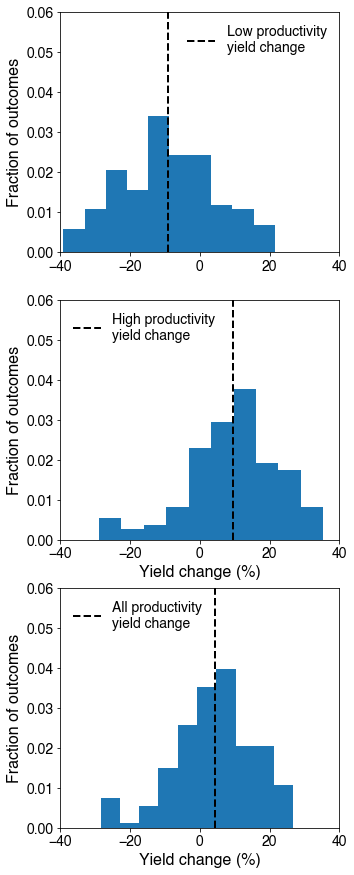

In [46]:
startPeriod = range(2, 15)
endPeriod = range(2, 15)

pl = []
ph = []
pa = []

for sp in startPeriod:
    for ep in endPeriod:
        startingYields = np.array(list(countyList['maizeYield']))
        startingYields = np.nanmean(startingYields[:, 0:sp], axis=1)

        indLow = np.where((startingYields < np.nanpercentile(startingYields, 25)))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, 75)))[0]

        gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['gdd']))[indLow]])))
        kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['kdd']))[indLow]])))
        prAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['seasonalPrecip']))[indLow]])))
        
        gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['gdd']))[indLow]])))
        kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['kdd']))[indLow]])))
        prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['seasonalPrecip']))[indLow]])))
        
        gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['gdd']))])))
        kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['kdd']))])))
        prAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['seasonalPrecip']))])))
        
        gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['gdd']))])))
        kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['kdd']))])))
        prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['seasonalPrecip']))])))

        gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['gdd']))[indHigh]])))
        kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['kdd']))[indHigh]])))
        prAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for x in np.array(list(usCounties['seasonalPrecip']))[indHigh]])))

        gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['gdd']))[indHigh]])))
        kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['kdd']))[indHigh]])))
        prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-(ep-1):] for x in np.array(list(usCounties['seasonalPrecip']))[indHigh]])))

        XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2}
        XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2}
        XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2}
        XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2}
        XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2}
                                                                     

        predLow = (mdl.predict(XLowEnd).mean()-mdl.predict(XLowStart).mean())/mdl.predict(XLowStart).mean()*100
        predHigh = (mdl.predict(XHighEnd).mean()-mdl.predict(XHighStart).mean())/mdl.predict(XHighStart).mean()*100
        predAll = (mdl.predict(XAllEnd).mean()-mdl.predict(XAllStart).mean())/mdl.predict(XAllStart).mean()*100

        pl.append(predLow)
        ph.append(predHigh)
        pa.append(predAll)

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-40, 40])
ax1.set_ylim([0, .06])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmean(pl), np.nanmean(pl)], [0, 1], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-40, 40])
ax2.set_ylim([0, .06])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmean(ph), np.nanmean(ph)], [0, 1], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-40, 40])
ax3.set_ylim([0, .06])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmean(pa), np.nanmean(pa)], [0, 1], '--k', lw=2, label='All productivity\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

scipy.stats.ks_2samp(pl, pa)
scipy.stats.ks_2samp(ph, pa)

In [ ]:
# calculate trends in crop yields

for xlat in range(maize.shape[0]):
    for ylon in range(maize.shape[1]):
        nn = np.where(~np.isnan(maize[xlat, ylon, :]))[0]
        if nn.shape[0] > 10:#== maize.shape[2]:
            X = sm.add_constant(range(nn.size))
            mdl = sm.OLS(maize[xlat, ylon, nn], X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        
        nn = np.where(~np.isnan(soybean[xlat, ylon, :]))[0]
        if nn.shape[0] == soybean.shape[2]:
            X = sm.add_constant(range(soybean.shape[2]))
            mdl = sm.OLS(soybean[xlat, ylon, :], X).fit()
            soybeanTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(rice[xlat, ylon, :]))[0]
        if nn.shape[0] == rice.shape[2]:
            X = sm.add_constant(range(rice.shape[2]))
            mdl = sm.OLS(rice[xlat, ylon, :], X).fit()
            riceTrends[xlat, ylon] = mdl.params[1]
            
        nn = np.where(~np.isnan(wheat[xlat, ylon, :]))[0]
        if nn.shape[0] == wheat.shape[2]:
            X = sm.add_constant(range(wheat.shape[2]))
            mdl = sm.OLS(wheat[xlat, ylon, :], X).fit()
            wheatTrends[xlat, ylon] = mdl.params[1]

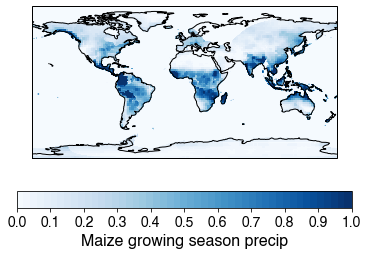

In [94]:
cRange=[0, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.add_feature(cartopy.feature.STATES, edgecolor='black')
c = plt.contourf(lon, lat, np.clip(np.nanmean(seasonalPrecip, axis=2), cRange[0], cRange[1]), cmap='Blues', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .1))
cbar.set_label('%s growing season precip'%crop)
ax.coastlines()

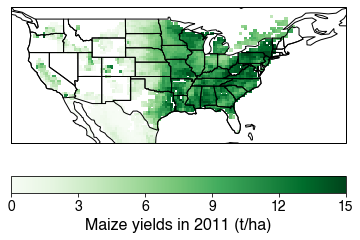

In [13]:
cRange=[0, 15]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.STATES, edgecolor='black')
ax.set_extent([-128,-58, 23, 46])
# c = plt.pcolormesh(lon, lat, np.clip(np.nanmean(maize[:,:,-11:],axis=2), cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
c = plt.pcolormesh(lon, lat, np.clip(maize[:,:,11], cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 3))
cbar.set_label('Maize yields in 2011 (t/ha)')
ax.coastlines()
plt.savefig('us-maize-yield-2011.pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0)

In [14]:
if os.path.isfile('%s/gdd-%s-coefs.dat'%(dataDirDiscovery, crop)) and os.path.isfile('%s/gdd-%s-coefs.dat'%(dataDirDiscovery, crop)):
    with gzip.open('%s/gdd-%s-coefs.dat'%(dataDirDiscovery, crop), 'rb') as f:
        gddMaizeCoef = pickle.load(f)

    with gzip.open('%s/kdd-%s-coefs.dat'%(dataDirDiscovery, crop), 'rb') as f:
        kddMaizeCoef = pickle.load(f)
else:
    gddMaizeCoef = np.full([maize.shape[0], maize.shape[1]], np.nan)
    kddMaizeCoef = np.full([maize.shape[0], maize.shape[1]], np.nan)

    for xlat in range(maize.shape[0]):
        for ylon in range(maize.shape[1]):
            nn = np.where((~np.isnan(maizeDetrend[xlat, ylon, :])) & (~np.isnan(gddDetrend[xlat, ylon, :])) & (~np.isnan(kddDetrend[xlat, ylon, :])))[0]

            if len(nn) > 10:
                data = {'GDD':gddDetrend[xlat, ylon, nn], 'KDD':kddDetrend[xlat, ylon, nn], \
                        'Yield':maizeDetrend[xlat, ylon, nn]}
                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', \
                                           'Yield'])
                mdl = smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
                gddMaizeCoef[xlat, ylon] = mdl.params['GDD']
                kddMaizeCoef[xlat, ylon] = mdl.params['KDD']

    with gzip.open('%s/gdd-%s-coefs.dat'%(dataDirDiscovery, crop), 'wb') as f:
        pickle.dump(gddMaizeCoef, f)

    with gzip.open('%s/kdd-%s-coefs.dat'%(dataDirDiscovery, crop), 'wb') as f:
        pickle.dump(kddMaizeCoef, f)


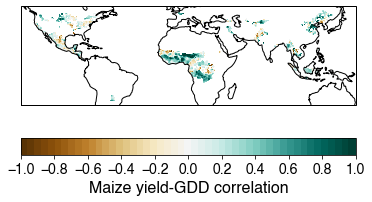

In [15]:
cRange=[-1, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(gddMaizeCoef, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .2))
cbar.set_label('%s yield-GDD correlation'%crop)
ax.coastlines()

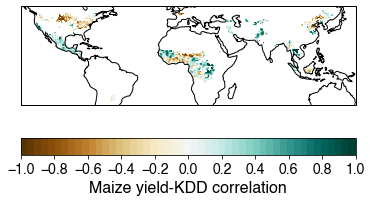

In [16]:
cRange=[-1, 1]
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lon, lat, np.clip(kddMaizeCoef, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .2))
cbar.set_label('%s yield-KDD correlation'%crop)
ax.coastlines()

In [17]:
# latUS = [30, 45]
# lonUS = [-105+360, -75+360]

# latIndUS = np.where((lat >= latUS[0]) & (lat <= latUS[1]))[0]
# lonIndUS = np.where((lon >= lonUS[0]) & (lon <= lonUS[1]))[0]

# maizeUS = maize[latIndUS, :, :]
# maizeUS = maizeUS[:, lonIndUS, :]

# maizeMean = np.nanmean(maizeUS[:,:,-10:], axis=2)
# maizeMean1d = np.reshape(maizeMean, [maizeMean.size])

# maizeTrendsUS = maizeTrends[latIndUS, :]
# maizeTrendsUS = maizeTrendsUS[:, lonIndUS]
# maizeTrends1d = np.reshape(maizeTrendsUS, [maizeTrendsUS.size])

# kddTrendsUS = kddTrends[latIndUS, :]
# kddTrendsUS = kddTrendsUS[:, lonIndUS]
# kddTrends1d = np.reshape(kddTrendsUS, [kddTrendsUS.size])

# gddTrendsUS = gddTrends[latIndUS, :]
# gddTrendsUS = gddTrendsUS[:, lonIndUS]
# gddTrends1d = np.reshape(gddTrendsUS, [gddTrendsUS.size])

# kddAvgUS = kdd[latIndUS, :, :]
# kddAvgUS = kddAvgUS[:, lonIndUS, :]
# kddAvg1d = np.reshape(np.nanmean(kddAvgUS, axis=2), [np.nanmean(kddAvgUS, axis=2).size])

# gddAvgUS = gdd[latIndUS, :, :]
# gddAvgUS = gddAvgUS[:, lonIndUS, :]
# gddAvg1d = np.reshape(np.nanmean(gddAvgUS, axis=2), [np.nanmean(gddAvgUS, axis=2).size])

# gddMaizeCoefUS = gddMaizeCoef[latIndUS, :]
# gddMaizeCoefUS = gddMaizeCoefUS[:, lonIndUS]
# gddMaizeCoef1d = np.reshape(gddMaizeCoefUS, [gddMaizeCoefUS.size])

# kddMaizeCoefUS = kddMaizeCoef[latIndUS, :]
# kddMaizeCoefUS = kddMaizeCoefUS[:, lonIndUS]
# kddMaizeCoef1d = np.reshape(kddMaizeCoefUS, [kddMaizeCoefUS.size])

kddTrends1d = np.reshape(kddTrends, [kddTrends.size])
gddTrends1d = np.reshape(gddTrends, [gddTrends.size])

kddAvg1d = np.reshape(np.nanmean(kdd, axis=2), [np.nanmean(kdd, axis=2).size])
gddAvg1d = np.reshape(np.nanmean(gdd, axis=2), [np.nanmean(gdd, axis=2).size])

gddMaizeCoef1d = np.reshape(gddMaizeCoef, [gddMaizeCoef.size])
kddMaizeCoef1d = np.reshape(kddMaizeCoef, [kddMaizeCoef.size])

maizeTrends1d = np.reshape(maizeTrends, [maizeTrends.size])

maizeMean = np.nanmean(maize[:,:,-10:], axis=2)
maizeMean1d = np.reshape(maizeMean, [maizeMean.size])

nn = np.where((~np.isnan(kddTrends1d)) & (~np.isnan(gddTrends1d)) & (~np.isnan(maizeMean1d)) & (~np.isnan(maizeTrends1d)))[0]
kddTrends1dNn = kddTrends1d[nn]
gddTrends1dNn = gddTrends1d[nn]
maizeMean1dNn = maizeMean1d[nn]
maizeTrends1dNn = maizeTrends1d[nn]
gddMaizeCoef1dNn = gddMaizeCoef1d[nn]
kddMaizeCoef1dNn = kddMaizeCoef1d[nn]
kddAvg1dNn = kddAvg1d[nn]
gddAvg1dNn = gddAvg1d[nn]

Text(0, 0.5, 'Yield response\nper\nexposure day')

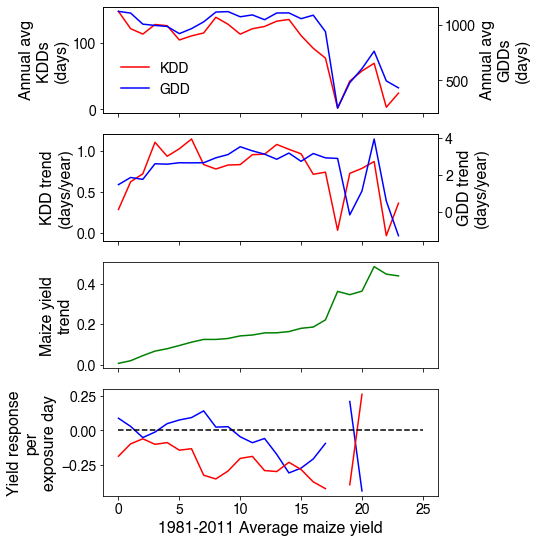

In [18]:
bins = np.arange(0, 28, 3)
binCounts = np.zeros(bins.shape)
kddMeans = []
gddMeans = []
kddTotals = []
gddTotals = []
kddCoefs = []
gddCoefs = []
yieldTrendMeans = []
for b, bv in enumerate(bins[:-1]):
    ind = np.where((maizeMean1dNn > bv) & (maizeMean1dNn <= bins[b+1]))[0]
    binCounts[b] = ind.size
    kddMeans.append(np.nanmean(kddTrends1dNn[ind]))
    gddMeans.append(np.nanmean(gddTrends1dNn[ind]))
    kddCoefs.append(np.nanmean(kddMaizeCoef1dNn[ind]))
    gddCoefs.append(np.nanmean(gddMaizeCoef1dNn[ind]))
    kddTotals.append(np.nanmean(kddAvg1dNn[ind]))
    gddTotals.append(np.nanmean(gddAvg1dNn[ind]))
    yieldTrendMeans.append(np.nanmean(maizeTrends1dNn[ind]))

f, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(6, 9), nrows=4, ncols=1, sharex='col', squeeze=True)

ax1.plot(bins[:-1],kddTotals, 'r', label='KDD')
ax1.set_ylabel('Annual avg\nKDDs \n(days)')
# ax1.set_yticks([30, 60, 90, 120])

ax1_2 = ax1.twinx()
ax1_2.plot(bins[:-1], gddTotals, 'b', label='GDD')
# ax1_2.set_yticks([500, 750, 1000])
ax1_2.set_ylabel('Annual avg\nGDDs\n(days)')

leg = f.legend(prop = {'size':14, 'family':'Helvetica'}, \
                 loc='lower left', bbox_to_anchor=(.25, 0.67), framealpha=0.75)
leg.get_frame().set_linewidth(0.0)

ax2.plot(bins[:-1],kddMeans, 'r')
ax2.set_ylabel('KDD trend\n(days/year)')
# ax2.set_yticks([0, .3, .6, .9])

ax2_2 = ax2.twinx()
ax2_2.plot(bins[:-1],gddMeans, 'b')
ax2_2.set_ylabel('GDD trend\n(days/year)')
# ax2_2.set_yticks([1.5, 2, 2.5, 3, 3.5])

ax3.plot(bins[:-1], yieldTrendMeans, 'g')
ax3.set_ylabel('Maize yield\ntrend')
# ax3.set_yticks([0, .2, .4])

ax4.plot(bins[:-1], gddCoefs, 'b')
ax4.plot(bins[:-1], kddCoefs, 'r')
ax4.plot([0, 25], [0, 0], '--k')
ax4.set_xlabel('1981-2011 Average maize yield')
ax4.set_ylabel('Yield response\nper\nexposure day')
# plt.savefig('yield-kdd-gdd.pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0)

In [20]:
maizeDetrend1d = np.reshape(maizeDetrend, [maizeDetrend.size])
gddDetrend1d = np.reshape(gddDetrend, [gddDetrend.size])
kddDetrend1d = np.reshape(kddDetrend, [kddDetrend.size])

maizeMean = np.nanmean(maize, axis=2)
maizeMean = np.moveaxis(np.tile(maizeMean, (maize.shape[2], 1, 1)), 0, 2)
maizeMean1d = np.reshape(maizeMean, [maizeMean.size])

maizeIndThreshTop = np.where(maizeMean1d > np.nanpercentile(maizeMean1d, 50))[0]
maizeIndThreshBottom = np.where(maizeMean1d < np.nanpercentile(maizeMean1d, 50))[0]

Text(0.5, 1.0, 'Global > 50th yield percentile')

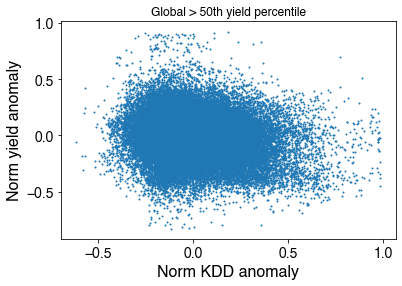

In [21]:
dataTop = {'GDD':gddDetrend1d[maizeIndThreshTop], 'KDD':kddDetrend1d[maizeIndThreshTop], \
        'GDD2':gddDetrend1d[maizeIndThreshTop]**2, 'KDD2':kddDetrend1d[maizeIndThreshTop]**2, \
        'Yield':maizeDetrend1d[maizeIndThreshTop]}
dfTop = pd.DataFrame(dataTop, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])

plt.scatter(kddDetrend1d[maizeIndThreshTop], maizeDetrend1d[maizeIndThreshTop], s=1)
plt.xlabel('Norm KDD anomaly')
plt.ylabel('Norm yield anomaly')
plt.title('Global > 50th yield percentile')

In [22]:
# build the FE model - the 'C' operator marks those variables as fixed effects (from R-style syntax)
mdl=smf.rlm(formula='Yield ~ GDD + KDD + GDD2 + KDD2', data=dfTop).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:                61318
Model:                            RLM   Df Residuals:                    61313
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 24 Feb 2020                                         
Time:                        14:54:29                                         
No. Iterations:                    25                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0077      0.001      8.792      0.000       0.006       0.009
GDD           -0.0540      0.006     -9.664      0.000      -0.065      -0.043
KDD           -0.1189      0.006    -19.028      0.000      -0.131      -0.107
GDD2           0.0239      0.017      1.417      0.156      -0.009       0.057
KDD2          -0.2041      0.014    -14.207      0.000      -0.232      -0.176
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [23]:
gddMean = np.nanmean(gdd, axis=2)
gddMean = np.reshape(gddMean, [gddMean.size])

kddMean = np.nanmean(kdd, axis=2)
kddMean = np.reshape(kddMean, [kddMean.size])

maizeMean = np.nanmean(maize, axis=2)
maizeMean = np.reshape(maizeMean, [maizeMean.size])

In [24]:
kddTrends1d = np.reshape(kddTrends, [kddTrends.size])
nn = np.where(~np.isnan(kddTrends1d))[0]
kddTrends1dNorm = kddTrends1d
kddTrends1dNorm[nn] = kddTrends1d[nn]/np.linalg.norm(kddTrends1d[nn])

gddTrends1d = np.reshape(gddTrends, [gddTrends.size])
nn = np.where(~np.isnan(gddTrends1d))[0]
gddTrends1dNorm = gddTrends1d
gddTrends1dNorm[nn] = gddTrends1d[nn]/np.linalg.norm(gddTrends1d[nn])

maizeTrends1d = np.reshape(maizeTrends, [maizeTrends.size])
maizeTrends1d[maizeTrends1d == 0] = np.nan
soybeanTrends1d = np.reshape(soybeanTrends, [soybeanTrends.size])
riceTrends1d = np.reshape(riceTrends, [riceTrends.size])
wheatTrends1d = np.reshape(wheatTrends, [wheatTrends.size])

In [25]:
maizeMean1d = np.reshape(np.nanmean(maize, axis=2), [maize.shape[0]*maize.shape[1]])
maizePrc50 = np.nanpercentile(maizeMean1d, 50)
maizeIndAbove50p = np.where((maizeMean1d > maizePrc50) & (~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1d)))[0]
maizeIndBelow50p = np.where((maizeMean1d < maizePrc50) & (~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1d)))[0]

soybeanMean1d = np.reshape(np.nanmean(soybean, axis=2), [soybean.shape[0]*soybean.shape[1]])
soybeanPrc50 = np.nanpercentile(soybeanMean1d, 50)
soybeanIndAbove50p = np.where((soybeanMean1d > soybeanPrc50) & (~np.isnan(soybeanTrends1d)) & (~np.isnan(kddTrends1d)))[0]
soybeanIndBelow50p = np.where((soybeanMean1d < soybeanPrc50) & (~np.isnan(soybeanTrends1d)) & (~np.isnan(kddTrends1d)))[0]

riceMean1d = np.reshape(np.nanmean(rice, axis=2), [rice.shape[0]*rice.shape[1]])
ricePrc50 = np.nanpercentile(riceMean1d, 50)
riceIndAbove50p = np.where((riceMean1d > ricePrc50) & (~np.isnan(riceTrends1d)) & (~np.isnan(kddTrends1d)))[0]
riceIndBelow50p = np.where((riceMean1d < ricePrc50) & (~np.isnan(riceTrends1d)) & (~np.isnan(kddTrends1d)))[0]

wheatMean1d = np.reshape(np.nanmean(wheat, axis=2), [wheat.shape[0]*wheat.shape[1]])
wheatPrc50 = np.nanpercentile(wheatMean1d, 50)
wheatIndAbove50p = np.where((wheatMean1d > wheatPrc50) & (~np.isnan(wheatTrends1d)) & (~np.isnan(kddTrends1d)))[0]
wheatIndBelow50p = np.where((wheatMean1d < wheatPrc50) & (~np.isnan(wheatTrends1d)) & (~np.isnan(kddTrends1d)))[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:                 1426
Model:                            RLM   Df Residuals:                     1423
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 24 Feb 2020                                         
Time:                        14:54:29                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1246      0.002     80.893      0.000       0.122       0.128
GDD            7.8153      0.672     11.631      0.000       6.498       9.132
KDD           -7.6671      0.326    -23.494      0.000      -8.307      -7.028
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

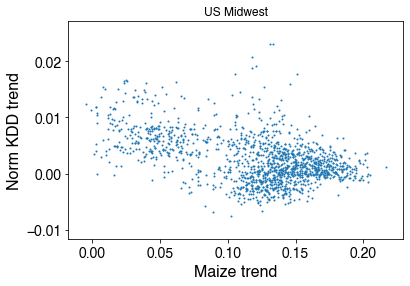

In [26]:
latUS = [30, 45]
lonUS = [-105+360, -75+360]

latIndUS = np.where((lat >= latUS[0]) & (lat <= latUS[1]))[0]
lonIndUS = np.where((lon >= lonUS[0]) & (lon <= lonUS[1]))[0]

maizeUS = maize[latIndUS, :, :]
maizeUS = maizeUS[:, lonIndUS, :]

maizeTrendsUS = maizeTrends[latIndUS, :]
maizeTrendsUS = maizeTrendsUS[:, lonIndUS]
maizeTrendsUS1d = np.reshape(maizeTrendsUS, [maizeTrendsUS.size])
maizeTrendsUS1d[maizeTrendsUS1d == 0] = np.nan

kddTrendsUS = kddTrends[latIndUS, :]
kddTrendsUS = kddTrendsUS[:, lonIndUS]
kddTrendsUS1d = np.reshape(kddTrendsUS, [kddTrendsUS.size])

gddTrendsUS = gddTrends[latIndUS, :]
gddTrendsUS = gddTrendsUS[:, lonIndUS]
gddTrendsUS1d = np.reshape(gddTrendsUS, [gddTrendsUS.size])

nn = np.where((~np.isnan(maizeTrendsUS1d)) & (~np.isnan(kddTrendsUS1d)) & (~np.isnan(gddTrendsUS1d)))[0]

plt.scatter(maizeTrendsUS1d[nn], kddTrendsUS1d[nn], s=1)
plt.xlabel('Maize trend')
plt.ylabel('Norm KDD trend')
plt.title('US Midwest')

data = {'GDD':gddTrendsUS1d[nn], 'KDD':kddTrendsUS1d[nn], \
        'GDD2':gddTrendsUS1d[nn]**2, 'KDD2':kddTrendsUS1d[nn]**2, \
        'Yield':maizeTrendsUS1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])
df = df.dropna()
mdl=smf.rlm(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     2441.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:54:30   Log-Likelihood:                 6221.6
No. Observations:               13857   AIC:                        -1.244e+04
Df Residuals:                   13854   BIC:                        -1.241e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -4.88e-16      0.001  -3.72e-13      1.000      -0.003       0.003
GDD           -0.0690      0.012     -5.577      0.000      -0.093      -0.045
KDD           -0.4531      0.012    -36.625      0.000      -0.477      -0.429
==============================================================================
Omnibus:                      478.730   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.514
Skew:                          -0.377   Prob(JB):                    3.68e-139
Kurtosis:                       3.733   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

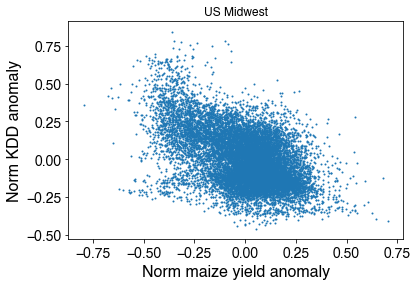

In [27]:
latUS = [30, 45]
lonUS = [-105+360, -75+360]

latIndUS = np.where((lat >= latUS[0]) & (lat <= latUS[1]))[0]
lonIndUS = np.where((lon >= lonUS[0]) & (lon <= lonUS[1]))[0]

maizeDetrendUS = maizeDetrend[latIndUS, :, :]
maizeDetrendUS = maizeDetrendUS[:, lonIndUS, :]
maizeDetrendUS1d = np.reshape(maizeDetrendUS, [maizeDetrendUS.size])

kddDetrendUS = kddDetrend[latIndUS, :, :]
kddDetrendUS = kddDetrendUS[:, lonIndUS, :]
kddDetrendUS1d = np.reshape(kddDetrendUS, [kddDetrendUS.size])

gddDetrendUS = gddDetrend[latIndUS, :]
gddDetrendUS = gddDetrendUS[:, lonIndUS]
gddDetrendUS1d = np.reshape(gddDetrendUS, [gddDetrendUS.size])

nn = np.where((~np.isnan(maizeDetrendUS1d)) & (~np.isnan(kddDetrendUS1d)) & (~np.isnan(gddDetrendUS1d)))[0]

plt.scatter(maizeDetrendUS1d[nn], kddDetrendUS1d[nn], s=1)
plt.xlabel('Norm maize yield anomaly')
plt.ylabel('Norm KDD anomaly')
plt.title('US Midwest')

data = {'GDD':gddDetrendUS1d[nn], 'KDD':kddDetrendUS1d[nn], \
        'Yield':maizeDetrendUS1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     26.39
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           7.04e-12
Time:                        14:54:30   Log-Likelihood:                 913.61
No. Observations:                 943   AIC:                            -1821.
Df Residuals:                     940   BIC:                            -1807.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1117      0.006     19.657      0.000       0.101       0.123
GDD            1.0302      0.959      1.075      0.283      -0.851       2.911
KDD           -8.5023      1.229     -6.916      0.000     -10.915      -6.090
==============================================================================
Omnibus:                      170.234   Durbin-Watson:                   0.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.667
Skew:                           1.066   Prob(JB):                     8.58e-71
Kurtosis:                       4.914   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

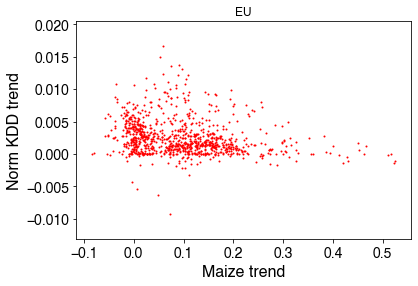

In [28]:
latEU = [30, 55]
lonEU = [-9+360, 30]

latIndEU = np.where((lat >= latEU[0]) & (lat <= latEU[1]))[0]
lonIndEU = np.where((lon >= lonEU[0]) | (lon <= lonEU[1]))[0]

maizeEU = maize[latIndEU, :, :]
maizeEU = maizeEU[:, lonIndEU, :]

maizeTrendsEU = maizeTrends[latIndEU, :]
maizeTrendsEU = maizeTrendsEU[:, lonIndEU]
maizeTrendsEU1d = np.reshape(maizeTrendsEU, [maizeTrendsEU.size])
maizeTrendsEU1d[maizeTrendsEU1d == 0] = np.nan

kddTrendsEU = kddTrends[latIndEU, :]
kddTrendsEU = kddTrendsEU[:, lonIndEU]
kddTrendsEU1d = np.reshape(kddTrendsEU, [kddTrendsEU.size])
kddTrendsEU1d[kddTrendsEU1d == 0] = np.nan

gddTrendsEU = gddTrends[latIndEU, :]
gddTrendsEU = gddTrendsEU[:, lonIndEU]
gddTrendsEU1d = np.reshape(gddTrendsEU, [gddTrendsEU.size])
gddTrendsEU1d[gddTrendsEU1d == 0] = np.nan

nn = np.where((~np.isnan(maizeTrendsEU1d)) & (~np.isnan(kddTrendsEU1d)) & (~np.isnan(gddTrendsEU1d)))[0]

plt.scatter(maizeTrendsEU1d[nn], kddTrendsEU1d[nn], color='r', s=1)
plt.xlabel('Maize trend')
plt.ylabel('Norm KDD trend')
plt.title('EU')

data = {'GDD':gddTrendsEU1d[nn], 'KDD':kddTrendsEU1d[nn], \
        'GDD2':gddTrendsEU1d[nn]**2, 'KDD2':kddTrendsEU1d[nn]**2, \
        'Yield':maizeTrendsEU1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'GDD2', 'KDD2', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  Yield   No. Observations:                 2976
Model:                            RLM   Df Residuals:                     2973
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 24 Feb 2020                                         
Time:                        14:54:30                                         
No. Iterations:                    13                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013      0.003      0.447      0.655      -0.004       0.007
GDD            0.0661      0.023      2.863      0.004       0.021       0.111
KDD           -0.5084      0.023    -22.014      0.000      -0.554      -0.463
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

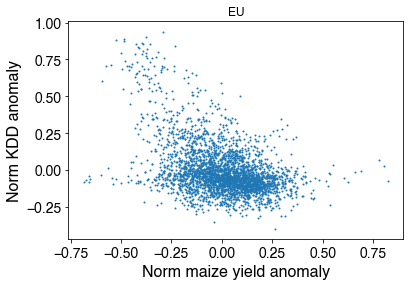

In [29]:
latEU = [30, 55]
lonEU = [-9+360, 30]

latIndEU = np.where((lat >= latEU[0]) & (lat <= latEU[1]))[0]
lonIndEU = np.where((lon >= lonEU[0]) | (lon <= lonEU[1]))[0]

maizeDetrendEU = maizeDetrend[latIndEU, :, :]
maizeDetrendEU = maizeDetrendEU[:, lonIndEU, :]
maizeDetrendEU1d = np.reshape(maizeDetrendEU, [maizeDetrendEU.size])

kddDetrendEU = kddDetrend[latIndEU, :, :]
kddDetrendEU = kddDetrendEU[:, lonIndEU, :]
kddDetrendEU1d = np.reshape(kddDetrendEU, [kddDetrendEU.size])

gddDetrendEU = gddDetrend[latIndEU, :]
gddDetrendEU = gddDetrendEU[:, lonIndEU]
gddDetrendEU1d = np.reshape(gddDetrendEU, [gddDetrendEU.size])

nn = np.where((~np.isnan(maizeDetrendEU1d)) & (~np.isnan(kddDetrendEU1d)) & (~np.isnan(gddDetrendEU1d)))[0]

plt.scatter(maizeDetrendEU1d[nn], kddDetrendEU1d[nn], s=1)
plt.xlabel('Norm maize yield anomaly')
plt.ylabel('Norm KDD anomaly')
plt.title('EU')

data = {'GDD':gddDetrendEU1d[nn], 'KDD':kddDetrendEU1d[nn], \
        'Yield':maizeDetrendEU1d[nn]}
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.rlm(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

In [30]:
nn = np.where((~np.isnan(maizeTrends1d)) & (~np.isnan(kddTrends1dNorm)) & (~np.isnan(gddTrends1dNorm)))[0]

data = {'GDD':gddTrends1dNorm[nn], 'KDD':kddTrends1dNorm[nn], \
        'Yield':maizeTrends1d[nn]}

df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', \
                           'Yield'])
df = df.dropna()
mdl=smf.ols(formula='Yield ~ GDD + KDD', data=df).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     79.31
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           5.54e-35
Time:                        14:54:30   Log-Likelihood:                 19558.
No. Observations:               14623   AIC:                        -3.911e+04
Df Residuals:                   14620   BIC:                        -3.909e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0591      0.001     95.103      0.000       0.058       0.060
GDD            1.2670      0.179      7.060      0.000       0.915       1.619
KDD            0.9277      0.175      5.298      0.000       0.584       1.271
==============================================================================
Omnibus:                     3871.073   Durbin-Watson:                   0.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16151.701
Skew:                           1.251   Prob(JB):                         0.00
Kurtosis:                       7.500   Cond. No.                         416.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""